## SFN 24 Experiments MLP

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from imports import *

In [9]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [10]:
# overall imports
import importlib
import data

# data load
importlib.reload(data.data_load)
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.base_models
from models.base_models import ModelBuild
importlib.reload(models.base_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics, plot_single_model_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [11]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()
print(f"Number of available GPUs: {torch.cuda.device_count()}")

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()

torch.cuda.empty_cache()


CPU Usage: 28.0%
RAM Usage: 5.3%
Available RAM: 953.4G
Total RAM: 1007.0G
52.4G
Number of available GPUs: 2
GPU found 0
XGBoost version: 2.0.3
cupy version: 13.1.0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |


## Table of Contents
- [Multidataset PLS](#PLS)
    - [AHBA+HCP](#AHBA)
    - [GTEx+HCP](#GTEx)
    - [UTSW+HCP](#UTSW)
- [AHBA+HCP](#AHBA)
    - [Bilinear PLS](#PLS-Sims)
      - [Random Splits](#PLS-Random-Splits)
    - [XGBoost](#XGBoost-Sims)
      - [Random Splits](#XGBoost-Random-Splits)

In [12]:
feature_types = [ 'transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']

### Random

In [14]:
feature = 'transcriptome'

print('FEATURE', feature)
single_sim_run(cv_type='random',
            model_type='mlp',
            feature_type=[feature],
            use_gpu=True,
            use_shared_regions=False,
            test_shared_regions=False,
            save_sim=True,
            search_method=('grid', 'pearson')
            )

FEATURE transcriptome
Number of components explaining 95.0% of the variance: 34
self X shape (114, 11053)
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 22106) (7140,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
GPU model input size 22106
Using 2 GPUs
Using 2 GPUs
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Using 2 GPUs
Epoch [10/200], Loss: 0.0318
Epoch [20/200], Loss: 0.0300
Epoch [30/200], Loss: 0.0297
Epoch [40/200], Loss: 0.0295
Epoch [50/200], Loss: 0.0290
Epoch [60/200], Loss: 0.0288
Epoch [70/200], Loss: 0.0289
Epoch [80/200], Loss: 0.0288
Epoch [90/200], Loss: 0.0286
Epoch [100/200], Loss: 0.0289
Epoch [110/200], Loss: 0.0288
Epoch [120/200], Loss: 0.0288
Epoch [130/200], Loss: 0.0285
Epoch [140/200], Loss: 0.0287
Epoch [150/200], Loss: 0.0284
Epoch [160/200], Loss: 0.0289
Epoch [170/200], Loss: 0.0288
Epoch [180/200], Loss: 0.0289
Epoch [190/200], Loss: 

TypeError: can only concatenate str (not "tuple") to str

### Community

In [ ]:
single_sim_run(cv_type='community',
                      model_type='mlp',
                      feature_type=[feature],
                      use_gpu=True,
                      use_shared_regions=False,
                      test_shared_regions=False,
                      save_sim=True,
                      resolution=1.01,
                      random_seed=1,
                      search_method=('grid', 'pearson')
                      )

In [ ]:
# loop these to search over different resolutions+seeds
resolutions = [1.01, 1.02]
seeds = [0, 1, 2, 3, 4, 5, 42]

for r in resolutions:
    for s in seeds:
        for feature in feature_types:
            print('FEATURE', feature)
            single_sim_run(cv_type='community',
                      model_type='xgboost',
                      feature_type=[feature],
                      use_gpu=True,
                      use_shared_regions=False,
                      test_shared_regions=False,
                      save_sim=True,
                      resolution=r,
                      random_seed=s,
                      search_method='bayes'
                      )

# DONE

FEATURE transcriptome
Number of components explaining 95.0% of the variance: 34
self X shape (114, 11053)
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(8930, 22106) (8930,) (342, 22106) (342,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=350, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.0001, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.609 total time=   8.9s
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=350, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.0001, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.086 total time=   4.0s
[CV 3/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=350, n_gpus=-1, random_state=

### Subnetwork

In [7]:
# bump bayesian down to 20 iters due to search space
for feature in feature_types:
    print('FEATURE', feature)
    single_sim_run(cv_type='schaefer',
              model_type='xgboost',
              feature_type=[feature],
              use_gpu=True,
              use_shared_regions=False,
              test_shared_regions=False,
              save_sim=True,
              resolution=1.02,
              random_seed=42,
              search_method='bayes'
              )

FEATURE transcriptome
Number of components explaining 95.0% of the variance: 34
Vis
Vis
SomMot
SomMot
DorsAttn
DorsAttn
SalVentAttn
SalVentAttn
Limbic
Limbic
Cont
Cont
Default
Default
Subcortical
Subcortical
self X shape (114, 11053)
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...

 Test fold num: 1
(9312, 22106) (9312,) (272, 22106) (272,)
SomMot
DorsAttn
SalVentAttn
Limbic
Cont
Default
Subcortical
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
ACCELERATING
Fitting 7 folds for each of 10 candidates, totalling 70 fits
[CV 1/7] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=350, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.0001, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.191 total time=   8.5s
[CV 2/7] END c

ValueError: Input y contains NaN.

## Results Analysis

### Random

In [9]:
SFN_sim_path = os.getcwd() + '/sim/sim_results/SFN_runs'
os.listdir(SFN_sim_path)

['structural_xgboost_random_bayessearch.pickle',
 'transcriptomePCA euclidean_xgboost_random_bayessearch.pickle',
 'transcriptome transcriptomePCA_xgboost_random_bayessearch.pickle',
 'structural_xgboost_community_bayessearch101_42.pickle',
 'transcriptomePCA structural_xgboost_random_bayessearch.pickle',
 'structural functional_xgboost_random_bayessearch.pickle',
 'structural euclidean functional_xgboost_random_bayessearch.pickle',
 'transcriptome functional_xgboost_random_bayessearch.pickle',
 'transcriptome structural_xgboost_random_bayessearch.pickle',
 'transcriptomePCA functional_xgboost_random_bayessearch.pickle',
 'transcriptomePCA structural euclidean_xgboost_random_bayessearch.pickle',
 'transcriptome_xgboost_community_bayessearch101_42.pickle',
 'structural euclidean_xgboost_random_bayessearch.pickle',
 'transcriptome transcriptomePCA structural_xgboost_random_bayessearch.pickle',
 'transcriptomePCA euclidean_xgboost_random_gridsearch.pickle',
 'transcriptomePCA_xgboost_comm

In [139]:
xgboost_random_bayessearch = open_pickled_results('transcriptome transcriptomePCA euclidean_xgboost_random_bayessearch.pickle', 'SFN_runs/')

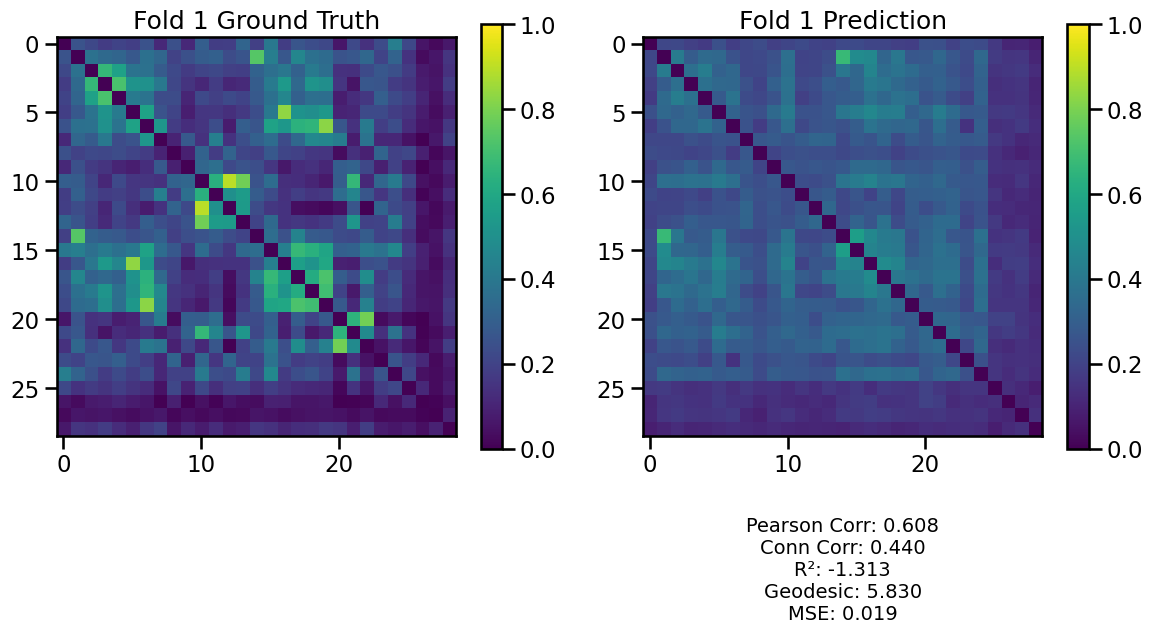

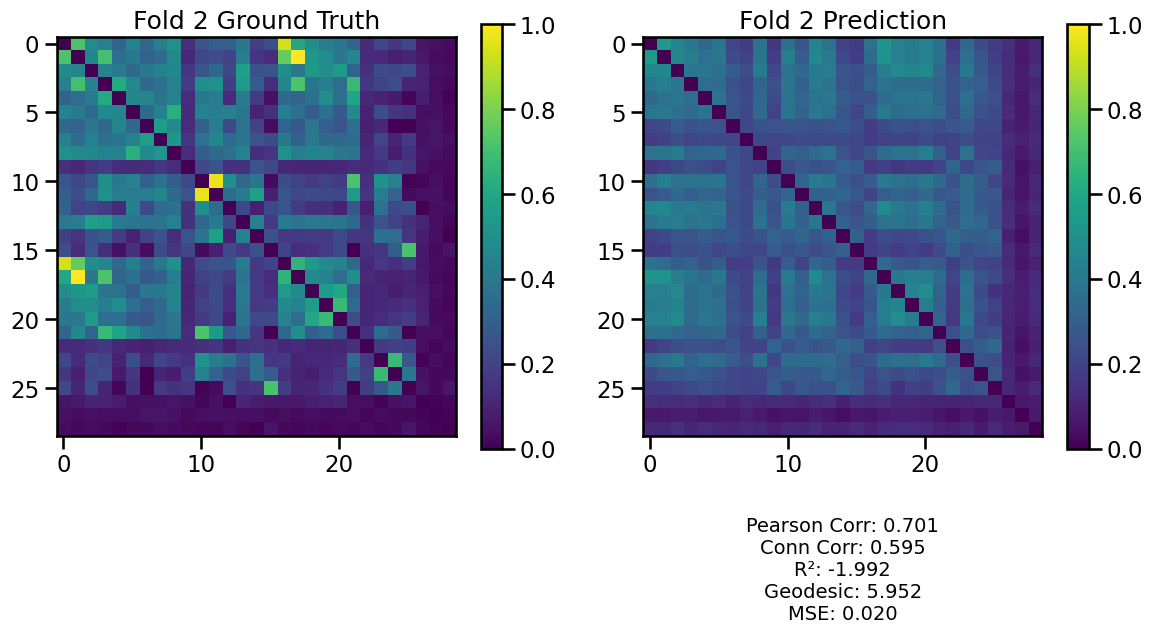

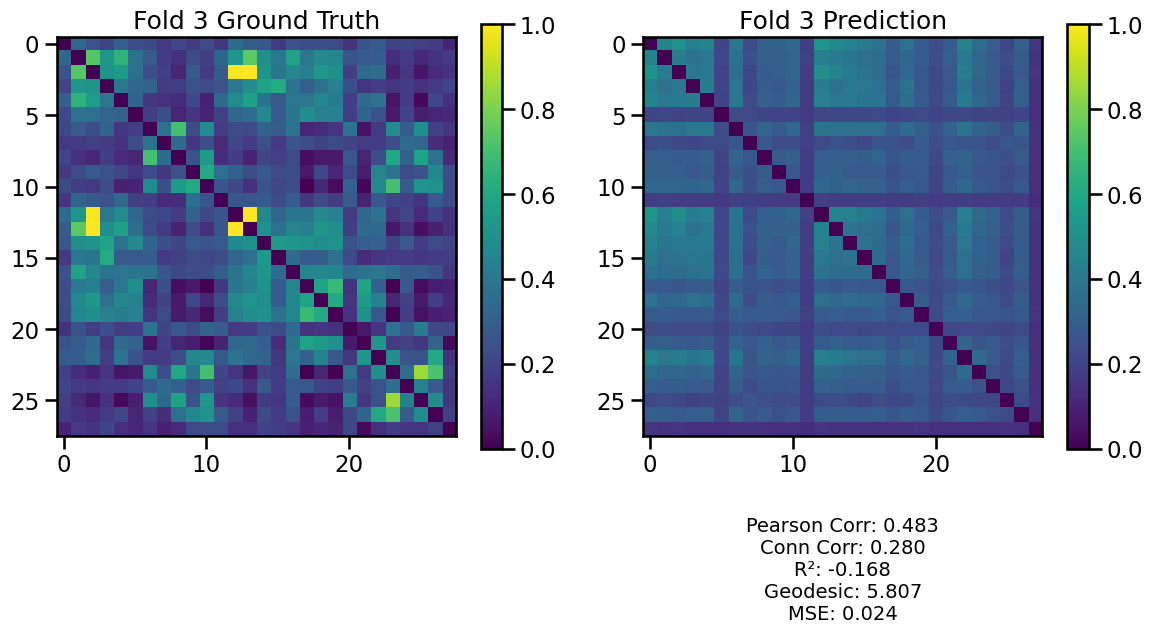

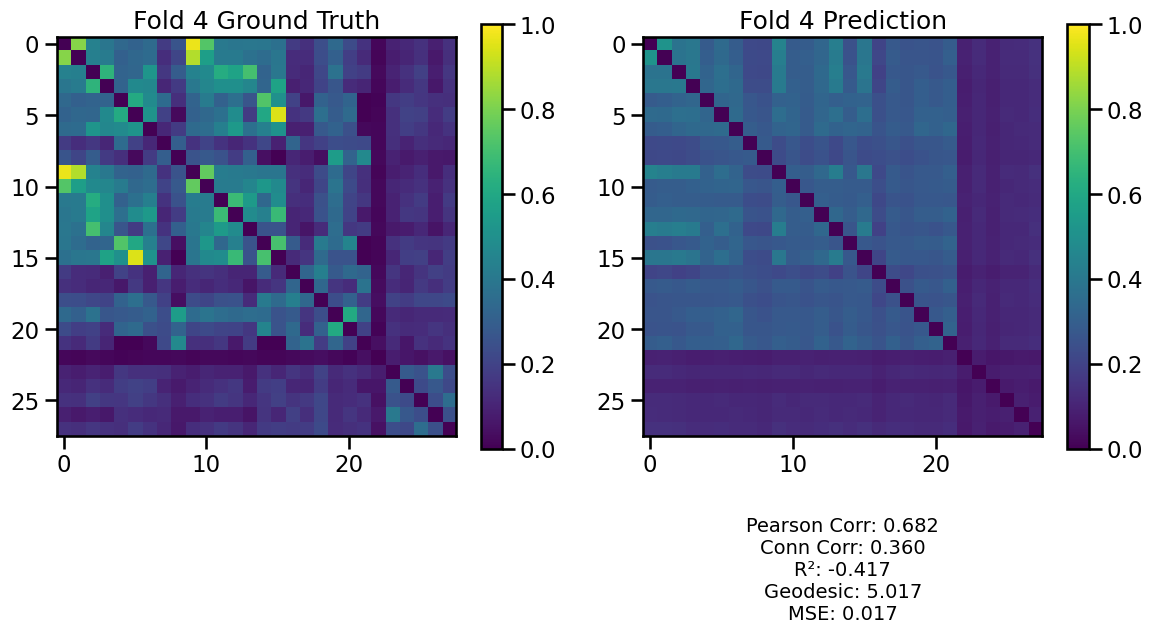

In [140]:
plot_single_model_predictions_with_metrics(xgboost_random_bayessearch)

In [141]:
xgboost_random_bayessearch = open_pickled_results('transcriptome_xgboost_random_bayessearch.pickle', 'SFN_runs/')

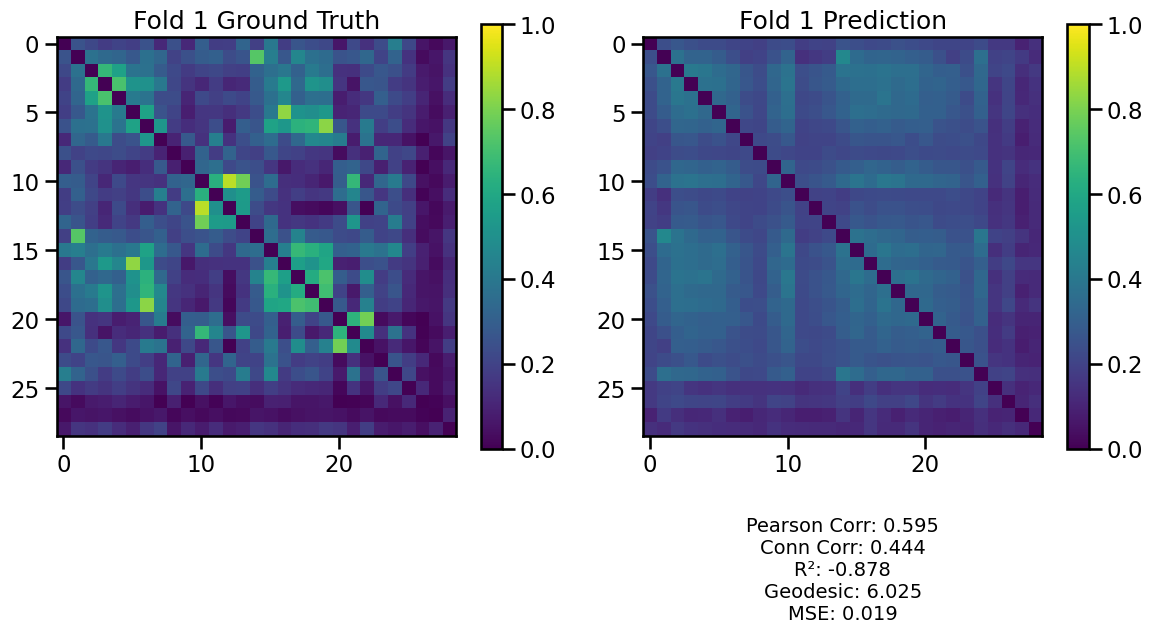

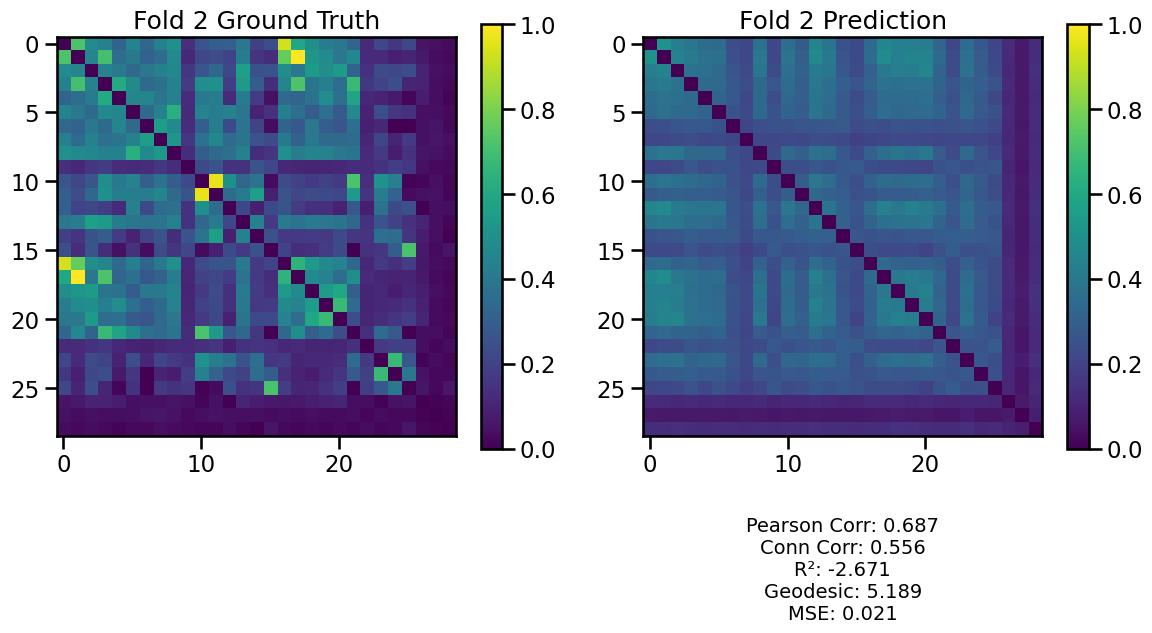

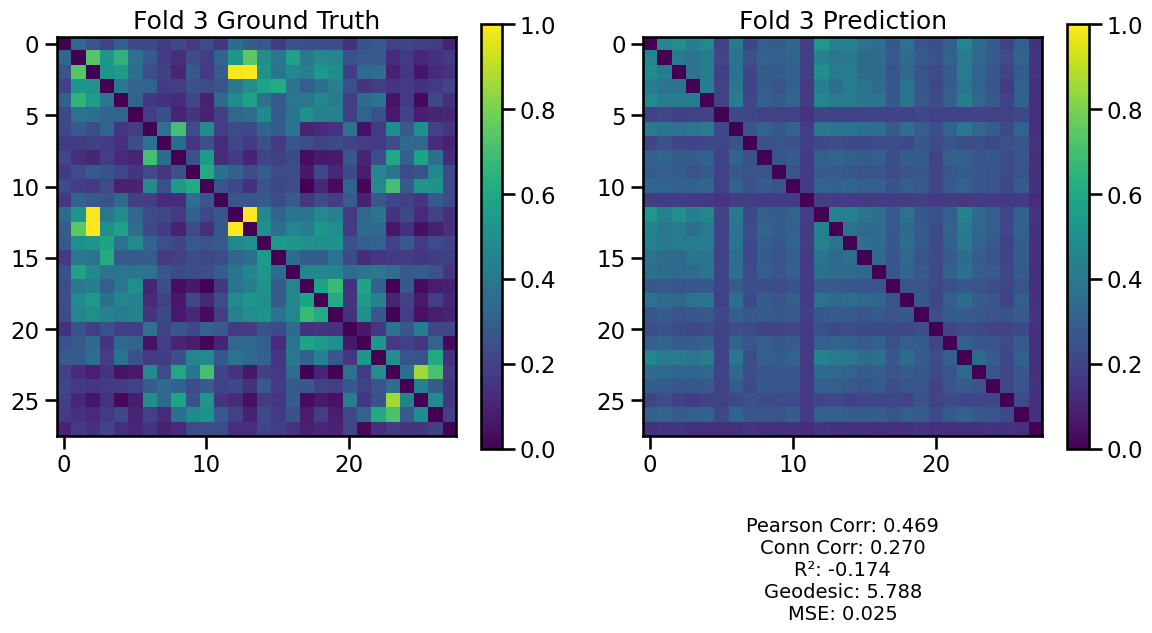

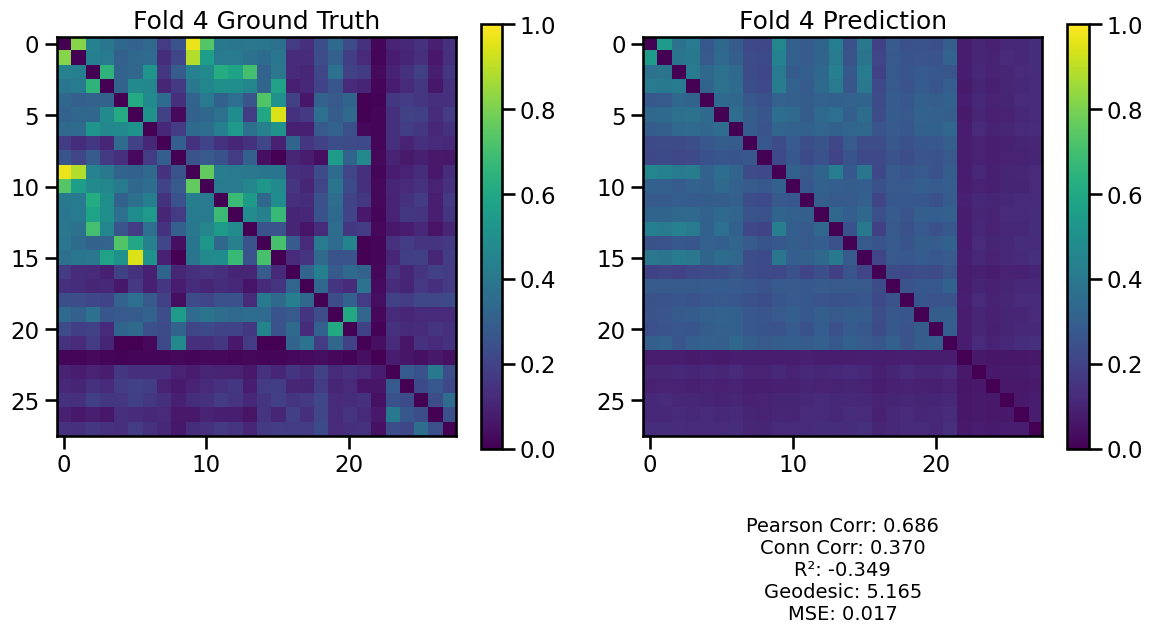

In [142]:
plot_single_model_predictions_with_metrics(xgboost_random_bayessearch)

In [143]:
xgboost_random_bayessearch = open_pickled_results('euclidean_xgboost_random_bayessearch.pickle', 'SFN_runs/')

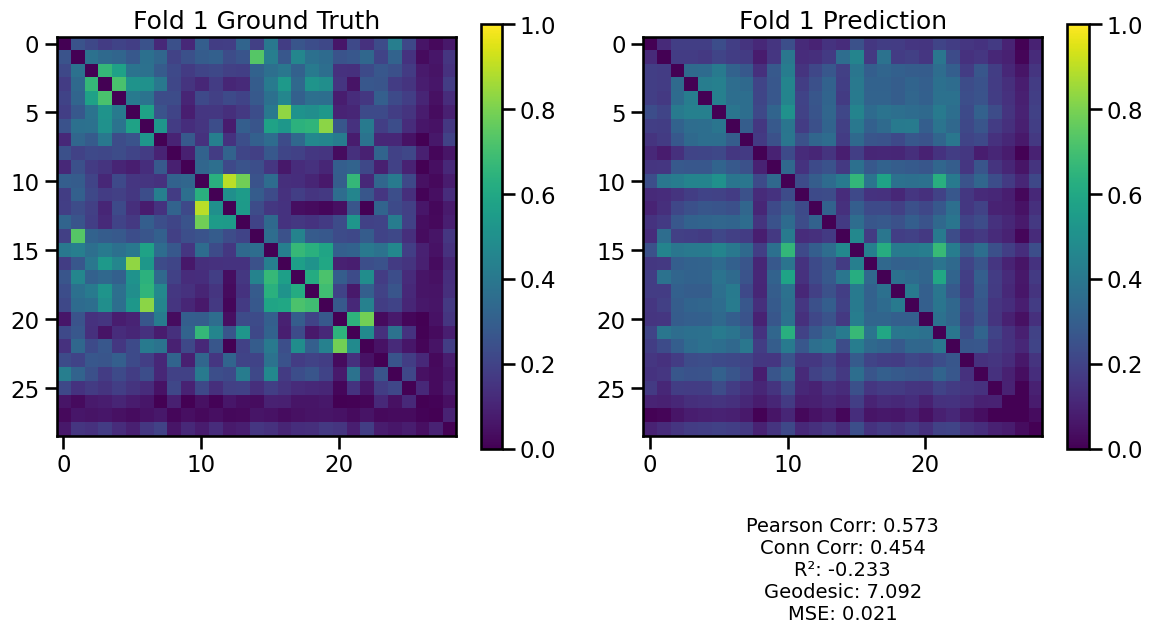

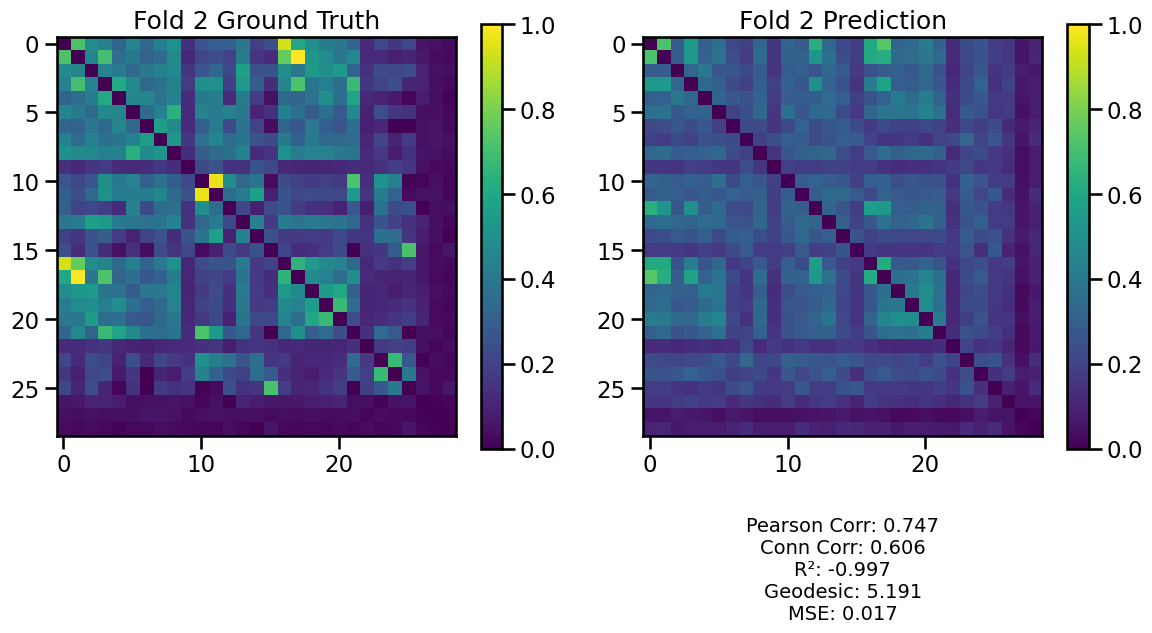

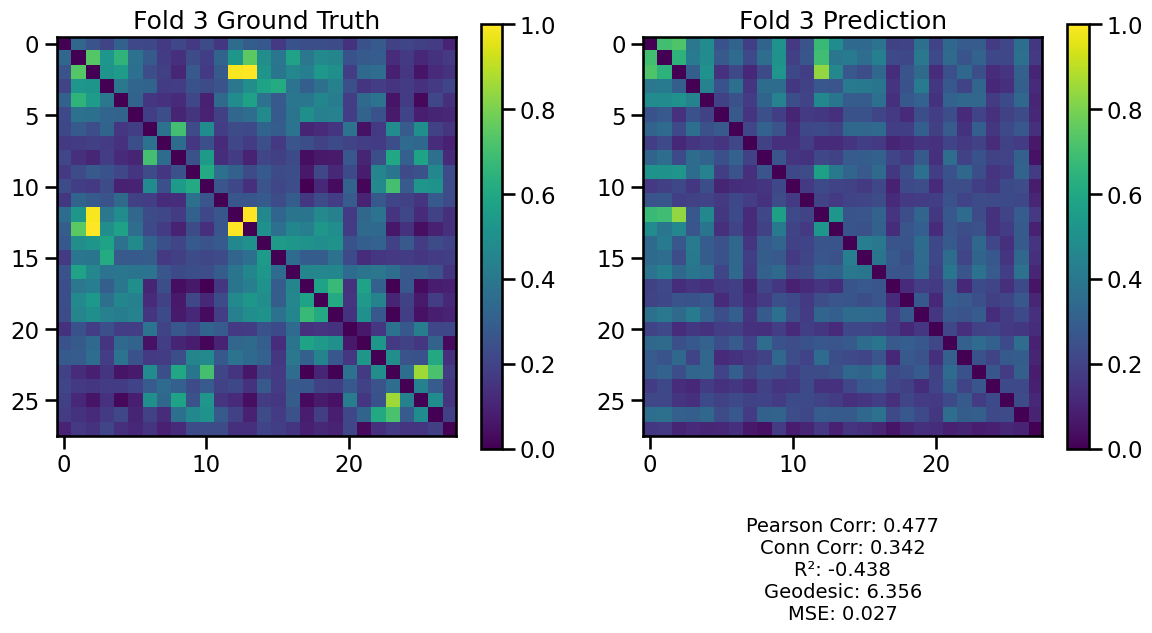

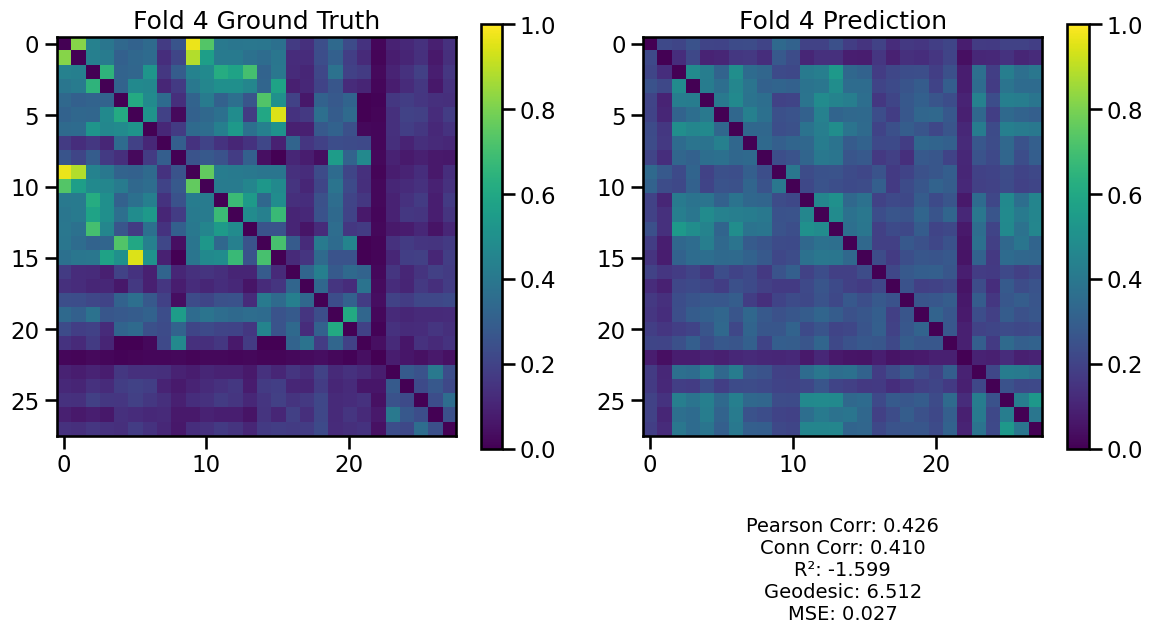

In [144]:
plot_single_model_predictions_with_metrics(xgboost_random_bayessearch)

In [145]:
xgboost_random_bayessearch = open_pickled_results('transcriptome euclidean_xgboost_random_bayessearch.pickle', 'SFN_runs/')

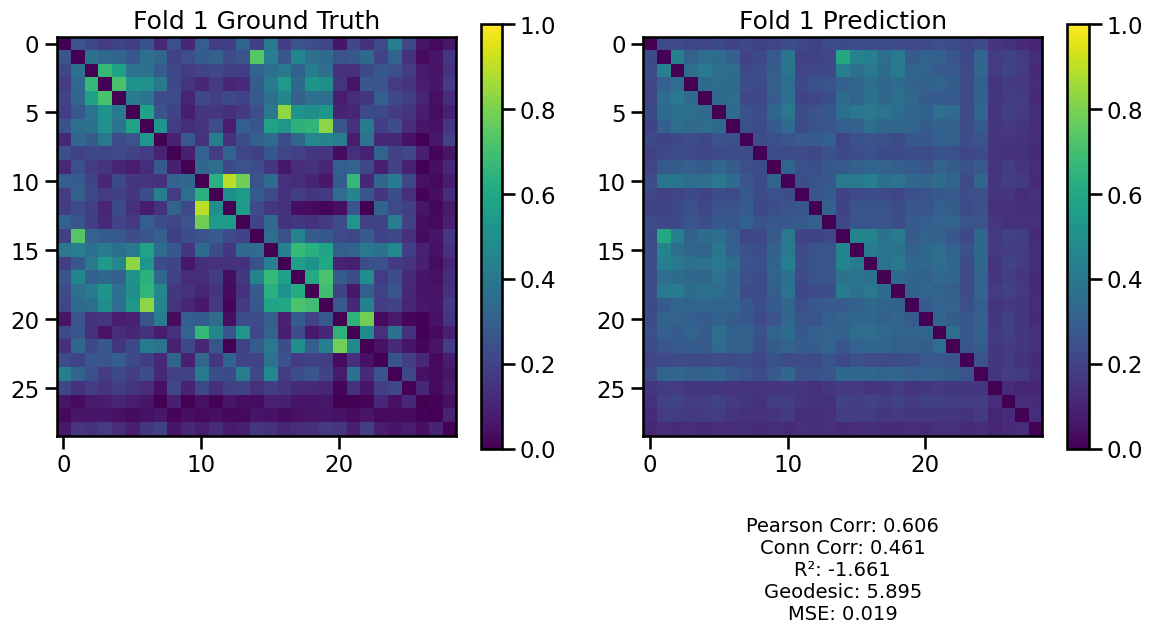

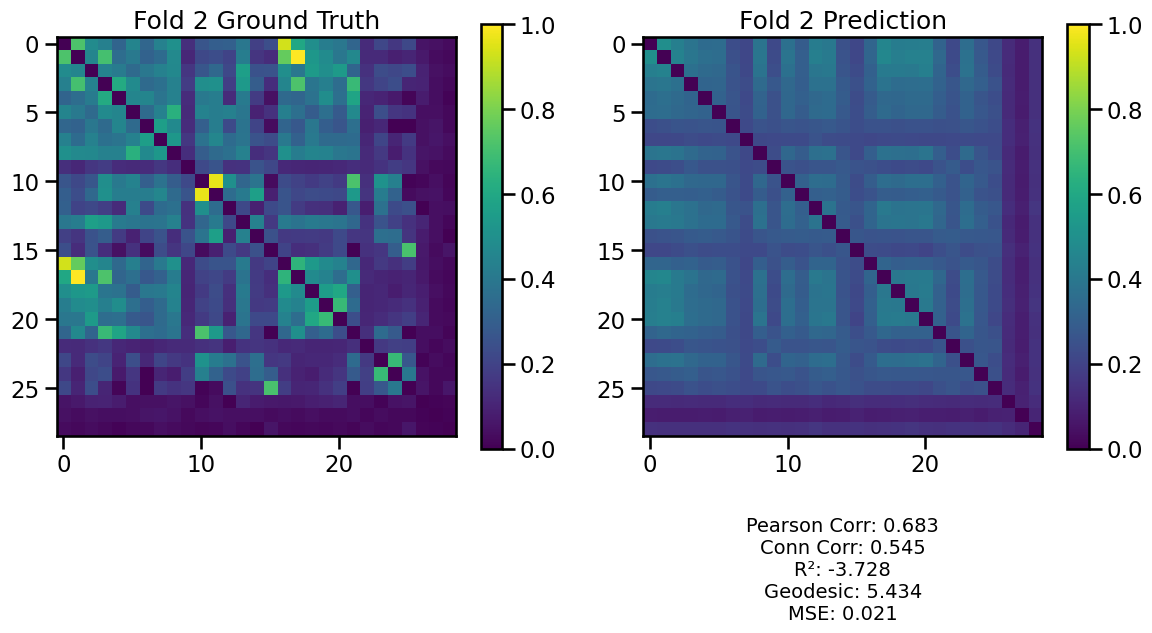

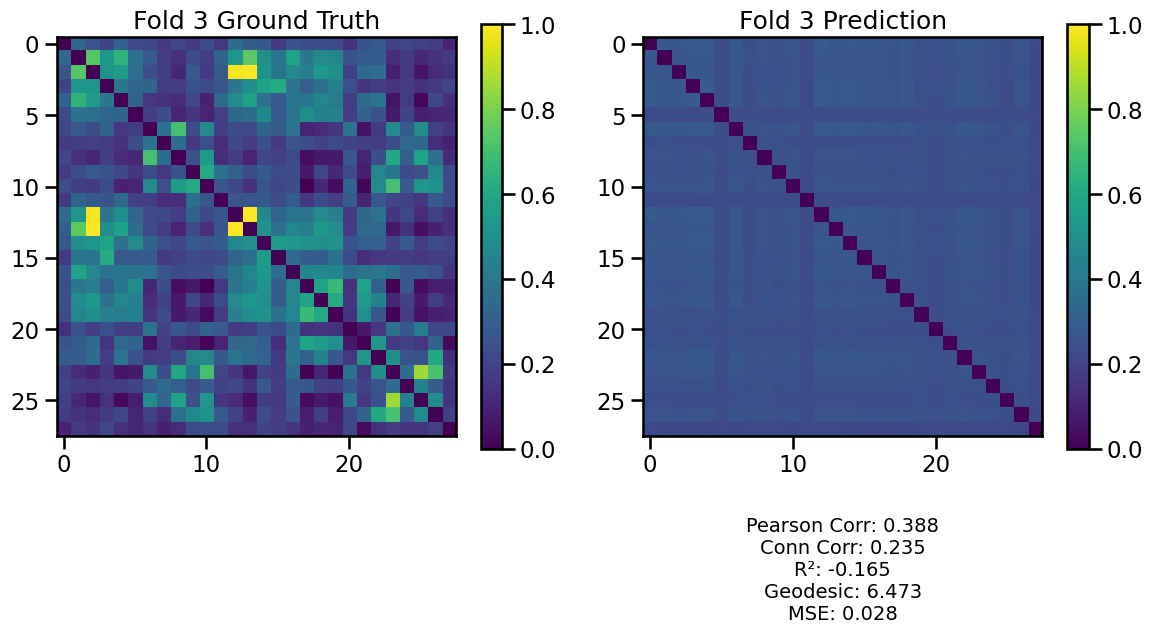

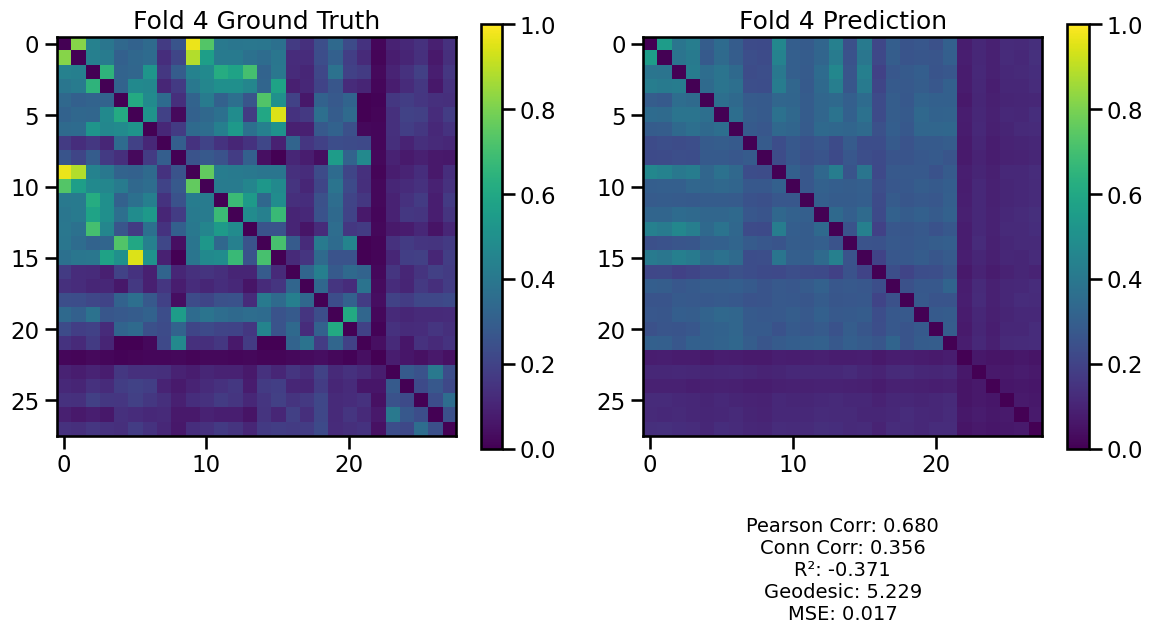

In [146]:
plot_single_model_predictions_with_metrics(xgboost_random_bayessearch)

In [148]:
def plot_performance(feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', 
                     display_train_test=True, sim_path=SFN_sim_path):
    """
    Iterate over each feature type, extract performance results from the pickle files,
    and generate a boxplot for performance metrics.
    
    Args:
    - feature_types: List of feature types.
    - model_type: The type of model to use (e.g., 'xgboost').
    - cv_split: The type of cross-validation split (e.g., 'random').
    - metric: The performance metric to extract (e.g., 'pearson_corr').
    - display_train_test: If True, shows both train and test metrics in the plot.
    - sim_path: Path to the saved pickle files.
    """
    data = []
    
    # Iterate over each feature type and load the corresponding results
    for feature in feature_types:
        print(f'Processing feature: {feature}')
        
        # Construct pickle file name pattern based on feature type, model type, and CV split
        pickle_file_pattern = f"{feature}_{model_type}_{cv_split}_bayessearch.pickle"
        
        # Check if the file exists
        if pickle_file_pattern in os.listdir(sim_path):
            # Extract the performance metrics for the train and test sets
            results = open_pickled_results(pickle_file_pattern, 'SFN_runs/')
            
            if results:
                # Iterate over each fold in the results (assuming fold results are directly stored)
                for fold_idx, fold_results in enumerate(results[0]):
                    #print(fold_idx)
                    #print(fold_results)

                    # Optionally include train metrics
                    if display_train_test:
                        train_score = fold_results['train_metrics'][metric]
                        data.append({'Feature Type': feature, 'Metric': metric, 'Fold': fold_idx, 
                                     'Score': train_score, 'Set': 'Train'})
                    # Extract test metrics
                    test_score = fold_results['test_metrics'][metric]
                    data.append({'Feature Type': feature, 'Metric': metric, 'Fold': fold_idx, 
                                 'Score': test_score, 'Set': 'Test'})
                    
                    
        else:
            print(f"Pickle file not found for feature: {feature}")

    # Convert to DataFrame for easy plotting with seaborn
    import pandas as pd
    results_df = pd.DataFrame(data)
    
    # Plot the results using seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Feature Type', y='Score', hue='Set', data=results_df)
    sns.swarmplot(x='Feature Type', y='Score', hue='Set', data=results_df, dodge=True, color=".25", size=5)
    
    plt.title(f'Performance Comparison of {model_type} ({cv_split} CV) on {metric}')
    plt.ylabel(f'{metric.capitalize()} Score')
    #plt.ylim(0, 0.8)
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


Processing feature: transcriptome
Processing feature: transcriptomePCA
Processing feature: structural
Processing feature: euclidean


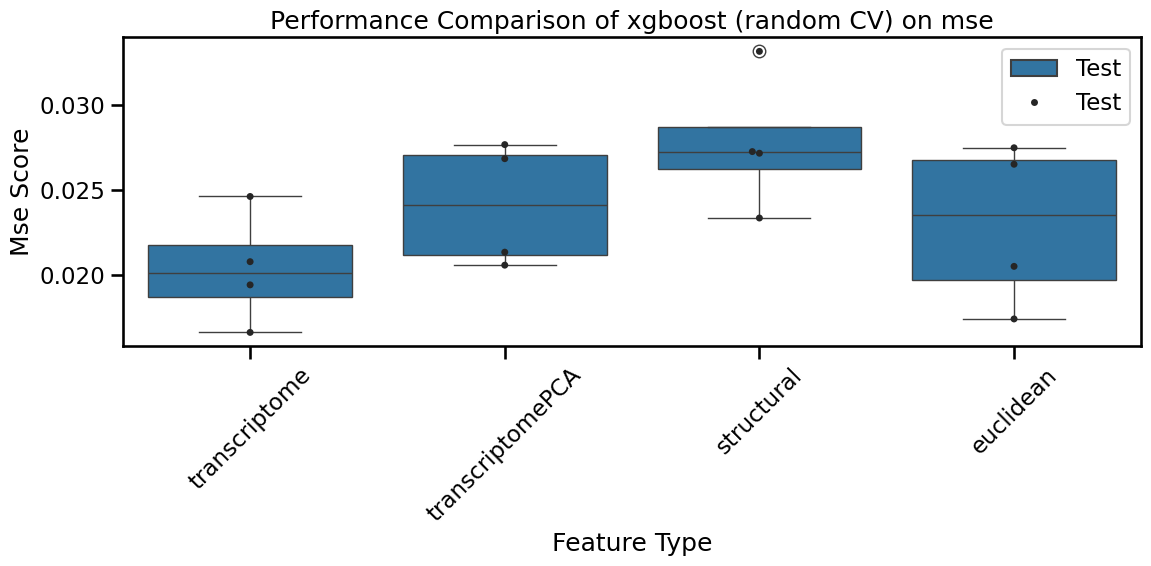

In [149]:
# Example usage
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean']

# Run the function to generate the plot for 'pearson_corr'
plot_performance(feature_types, model_type='xgboost', cv_split='random', metric='mse', display_train_test=False)

In [59]:
pairs = list(itertools.combinations(feature_types, 2))
pairs

pair_feature_types = ['transcriptome transcriptomePCA',
                     'transcriptome structural',
                     'transcriptome euclidean',
                     'transcriptomePCA structural',
                     'transcriptomePCA euclidean',
                     'structural euclidean']

Processing feature: transcriptome transcriptomePCA
Processing feature: transcriptome structural
Processing feature: transcriptome euclidean
Processing feature: transcriptomePCA structural
Processing feature: transcriptomePCA euclidean
Processing feature: structural euclidean


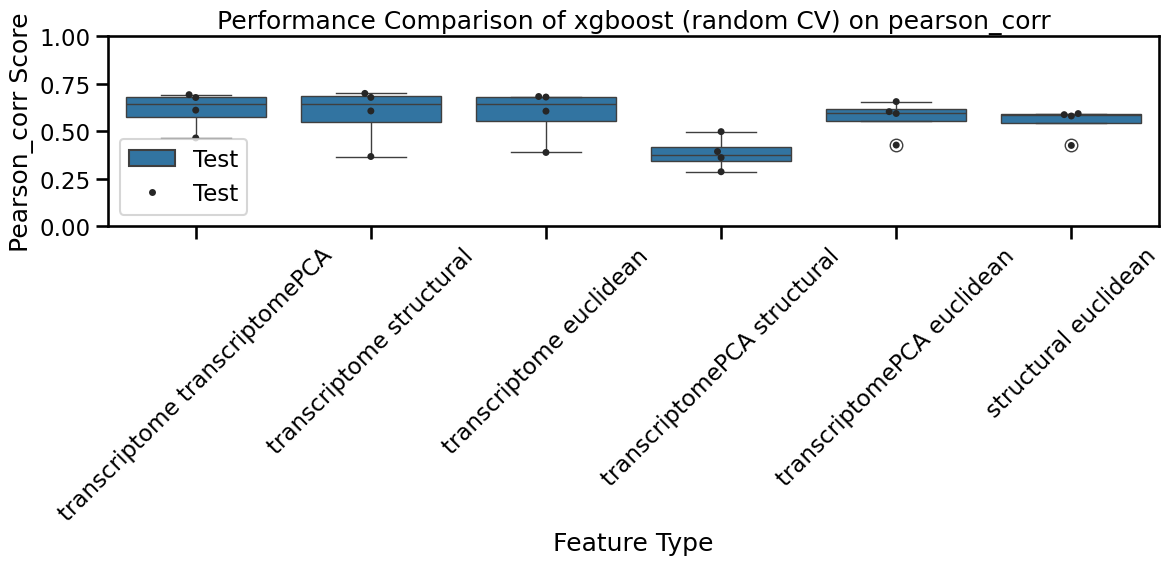

In [60]:
# Run the function to generate the plot for 'pearson_corr'
plot_performance(pair_feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', display_train_test=False)

In [61]:
triples = list(itertools.combinations(feature_types, 3))
triples

triple_feature_types = ['transcriptome transcriptomePCA structural',
 'transcriptome transcriptomePCA euclidean',
 'transcriptome structural euclidean',
 'transcriptomePCA structural euclidean']


Processing feature: transcriptome transcriptomePCA structural
Processing feature: transcriptome transcriptomePCA euclidean
Processing feature: transcriptome structural euclidean
Processing feature: transcriptomePCA structural euclidean


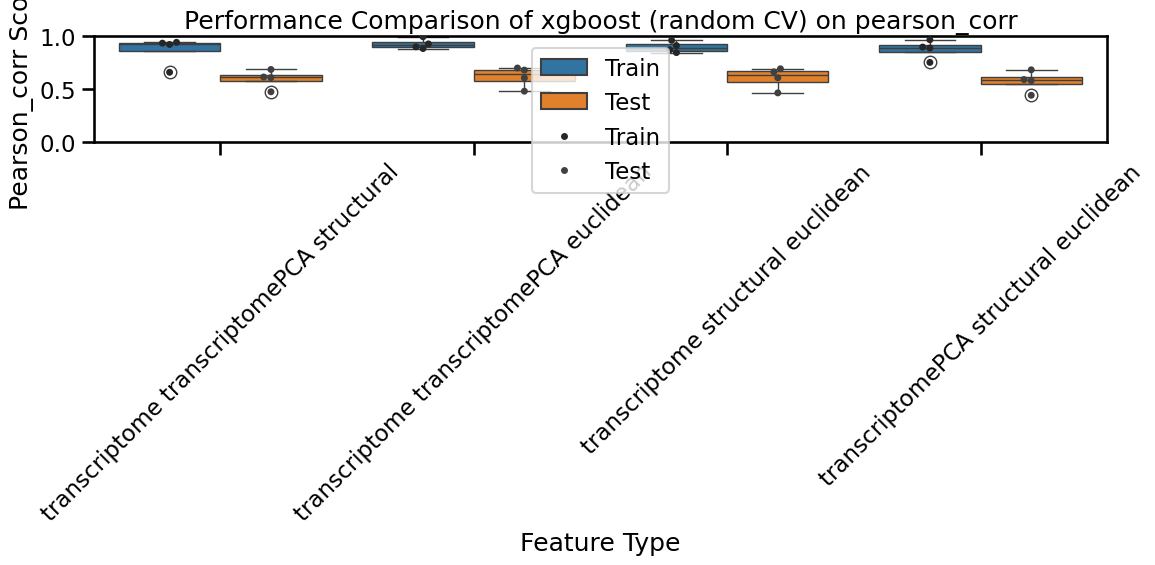

In [63]:
plot_performance(triple_feature_types, model_type='xgboost', cv_split='random', metric='pearson_corr', display_train_test=True)

In [109]:
def create_latex_table_as_html(SFN_sim_path, feature_types, metrics=['mse', 'mae', 'r2'], model_type='xgboost', cv_type='random', display_train=False):
    """
    Create a LaTeX table embedded within an HTML structure for model performance metrics.
    
    Parameters:
        SFN_sim_path (str): Path where the pickled simulation files are stored.
        feature_types (list): List of feature types to include in the table.
        metrics (list): List of metrics to include as rows in the table (e.g., ['mse', 'mae', 'r2']).
        model_type (str): The model type to filter the pickle files (default: 'xgboost').
        cv_type (str): The cross-validation type to filter the pickle files (default: 'random').
        display_train (bool): Whether to display training performance in addition to test performance.
    
    Returns:
        None: Generates LaTeX code embedded within an HTML structure.
    """
    def open_pickled_results(file, added_dir=''):
        """
        Function to open a pickle file and return the results.
        """
        pickle_file_path = f"{SFN_sim_path}/{file}"
        with open(pickle_file_path, "rb") as file:
            pickle_results = pickle.load(file)
        return pickle_results

    results_dict = {metric: {feature: [] for feature in feature_types} for metric in metrics}
    
    # Iterate over the feature types and open the corresponding pickle files
    for feature in feature_types:
        pickle_file = f"{feature}_{model_type}_{cv_type}_bayessearch.pickle"
        
        try:
            results = open_pickled_results(pickle_file, 'SFN_runs/')
            for fold in results[0]:
                for metric in metrics:
                    if display_train:
                        results_dict[metric][feature].append(fold['train_metrics'][metric])
                    else:
                        results_dict[metric][feature].append(fold['test_metrics'][metric])
        except FileNotFoundError:
            print(f"File not found: {pickle_file}")
            continue
    
    # Create the LaTeX table within an HTML structure
    html_table = '<table>\n<tr>\n'
    
    # Create table headers (metrics)
    html_table += '<th>Metric</th>' + ''.join([f'<th>{feature}</th>' for feature in feature_types]) + '\n</tr>\n'
    
    # Fill in the data for each metric
    for metric in metrics:
        html_table += '<tr>\n<td>{}</td>'.format(metric)
        for feature in feature_types:
            values = np.array(results_dict[metric][feature])
            if len(values) > 0:
                mean_val = np.mean(values)
                std_val = np.std(values)
                html_table += '<td>{:.4f} $\\pm$ {:.4f}</td>'.format(mean_val, std_val)
            else:
                html_table += '<td>N/A</td>'
        html_table += '\n</tr>\n'
    
    html_table += '</table>\n'

    # Add LaTeX caption at the end
    html_table += '<p>\\caption{Model performance for each feature type using ' + model_type + ' with ' + cv_type + ' cross-validation.}</p>'
    
    # Display the HTML-embedded LaTeX table as raw text (to be copied into a Markdown cell)
    print(html_table)

In [118]:
create_latex_table_as_html(SFN_sim_path, feature_types, metrics, model_type='xgboost', cv_type='random', display_train=False)

<table>
<tr>
<th>Metric</th><th>transcriptome</th><th>transcriptomePCA</th><th>structural</th><th>euclidean</th><th>functional</th>
</tr>
<tr>
<td>mse</td><td>0.0204 $\pm$ 0.0029</td><td>0.0241 $\pm$ 0.0032</td><td>0.0277 $\pm$ 0.0035</td><td>0.0230 $\pm$ 0.0042</td><td>0.0052 $\pm$ 0.0004</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.6095 $\pm$ 0.0892</td><td>0.5303 $\pm$ 0.0788</td><td>0.3973 $\pm$ 0.0637</td><td>0.5557 $\pm$ 0.1224</td><td>0.9315 $\pm$ 0.0049</td>
</tr>
</table>
<p>\caption{Model performance for each feature type using xgboost with random cross-validation.}</p>


In [111]:
create_latex_table_as_html(SFN_sim_path, pair_feature_types, metrics, model_type='xgboost', cv_type='random', display_train=False)

<table>
<tr>
<th>Metric</th><th>transcriptome transcriptomePCA</th><th>transcriptome structural</th><th>transcriptome euclidean</th><th>transcriptomePCA structural</th><th>transcriptomePCA euclidean</th><th>structural euclidean</th>
</tr>
<tr>
<td>mse</td><td>0.0204 $\pm$ 0.0028</td><td>0.0213 $\pm$ 0.0045</td><td>0.0214 $\pm$ 0.0042</td><td>0.0284 $\pm$ 0.0014</td><td>0.0221 $\pm$ 0.0025</td><td>0.0233 $\pm$ 0.0027</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.6113 $\pm$ 0.0903</td><td>0.5877 $\pm$ 0.1322</td><td>0.5891 $\pm$ 0.1202</td><td>0.3843 $\pm$ 0.0760</td><td>0.5698 $\pm$ 0.0859</td><td>0.5462 $\pm$ 0.0702</td>
</tr>
</table>
<p>\caption{Model performance for each feature type using xgboost with random cross-validation.}</p>


In [113]:
create_latex_table_as_html(SFN_sim_path, triple_feature_types, metrics, model_type='xgboost', cv_type='random', display_train=False)

<table>
<tr>
<th>Metric</th><th>transcriptome transcriptomePCA structural</th><th>transcriptome transcriptomePCA euclidean</th><th>transcriptome structural euclidean</th><th>transcriptomePCA structural euclidean</th>
</tr>
<tr>
<td>mse</td><td>0.0210 $\pm$ 0.0021</td><td>0.0200 $\pm$ 0.0026</td><td>0.0205 $\pm$ 0.0028</td><td>0.0222 $\pm$ 0.0022</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.5979 $\pm$ 0.0761</td><td>0.6182 $\pm$ 0.0857</td><td>0.6085 $\pm$ 0.0875</td><td>0.5758 $\pm$ 0.0858</td>
</tr>
</table>
<p>\caption{Model performance for each feature type using xgboost with random cross-validation.}</p>


<table>
<tr>
<th>Metric</th><th>transcriptome</th><th>transcriptomePCA</th><th>structural</th><th>euclidean</th><th>functional</th>
</tr>
<tr>
<td>mse</td><td>0.0204 $\pm$ 0.0029</td><td>0.0241 $\pm$ 0.0032</td><td>0.0277 $\pm$ 0.0035</td><td>0.0230 $\pm$ 0.0042</td><td>0.0052 $\pm$ 0.0004</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.6095 $\pm$ 0.0892</td><td>0.5303 $\pm$ 0.0788</td><td>0.3973 $\pm$ 0.0637</td><td>0.5557 $\pm$ 0.1224</td><td>0.9315 $\pm$ 0.0049</td>
</tr>
</table>

<table>
<tr>
<th>Metric</th><th>transcriptome transcriptomePCA</th><th>transcriptome structural</th><th>transcriptome euclidean</th><th>transcriptomePCA structural</th><th>transcriptomePCA euclidean</th><th>structural euclidean</th>
</tr>
<tr>
<td>mse</td><td>0.0204 $\pm$ 0.0028</td><td>0.0213 $\pm$ 0.0045</td><td>0.0214 $\pm$ 0.0042</td><td>0.0284 $\pm$ 0.0014</td><td>0.0221 $\pm$ 0.0025</td><td>0.0233 $\pm$ 0.0027</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.6113 $\pm$ 0.0903</td><td>0.5877 $\pm$ 0.1322</td><td>0.5891 $\pm$ 0.1202</td><td>0.3843 $\pm$ 0.0760</td><td>0.5698 $\pm$ 0.0859</td><td>0.5462 $\pm$ 0.0702</td>
</tr>
</table>

<table>
<tr>
<th>Metric</th><th>transcriptome transcriptomePCA structural</th><th>transcriptome transcriptomePCA euclidean</th><th>transcriptome structural euclidean</th><th>transcriptomePCA structural euclidean</th>
</tr>
<tr>
<td>mse</td><td>0.0210 $\pm$ 0.0021</td><td>0.0200 $\pm$ 0.0026</td><td>0.0205 $\pm$ 0.0028</td><td>0.0222 $\pm$ 0.0022</td>
</tr>
<tr>
<td>pearson_corr</td><td>0.5979 $\pm$ 0.0761</td><td>0.6182 $\pm$ 0.0857</td><td>0.6085 $\pm$ 0.0875</td><td>0.5758 $\pm$ 0.0858</td>
</tr>
</table>